<a href="https://colab.research.google.com/github/nikkipatl/genai/blob/main/customer_complaints_summarisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **This notebook explores genAI using the openAI API and fine-tunes a LLM with context from customer complaints data from Plusnet**


In [1]:
!pip install openai==1.7.2 python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.1/212.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import os, time
from openai import OpenAI
from dotenv import load_dotenv
import json
import matplotlib.pyplot as plt

print("Modules are imported.")

Modules are imported.


# Setting up the OpenAI API:

### Prepare a .env file to store the OpenAI API key.
### Uploading the .env file to our colab environment
### Load the API key and setup the API

In [5]:
load_dotenv('apikey.env.txt')

APIKEY = os.getenv('APIKEY')

In [6]:
client = OpenAI(
              api_key = APIKEY,

)
client

# Task 2 - Prepare the training data

In [10]:
training_data = pd.read_csv("Customer Complaints.csv")
training_data.head()

,Complaints,Details
0,Unreliable internet! Sick of constant outages...,"{""Topic"": ""Internet"", ""Problem"": ""Unreliable s..."
1,TV signal keeps dropping during crucial momen...,"{""Topic"": ""TV"", ""Problem"": ""Signal dropout"", ""..."
2,Phone line always crackling! Can't hear a thi...,"{""Topic"": ""Phone"", ""Problem"": ""Crackling line""..."
3,Ridiculous prices for such terrible service! ...,"{""Topic"": ""Billing"", ""Problem"": ""Overcharged"",..."
4,Internet speed slower than a snail! Can't str...,"{""Topic"": ""Internet"", ""Problem"": ""Slow speed"",..."


In [11]:
def save_as_json(row):

  system_content = """
      Given a customer complaint text, extract and return the following information in json (dict) format:
      - Topic: The product/department that the customer has a complaint about.
      - Problem: A two or three-word description of what exactly the problem is.
      - Customer_Dissatisfaction_Index: is a number between 0 and 100 showing
             how angry the customer is about the problem.
  """

  formatted_data = {
        "messages": [
            {"role": "system", "content": system_content},
            {"role": "user", "content": row.Complaints},
            {"role": "assistant", "content": row.Details}
        ]
      }

  with open("training_data.json", "a") as json_file:
        json.dump(formatted_data, json_file)
        json_file.write("\n")

In [12]:
for index, row in training_data.iterrows():
  save_as_json(row)

#Task 3 - Fine-tune GPT 3.5 based on our training data

In [13]:
data_file = client.files.create(
    file = open('training_data.json', 'rb'),
    purpose = 'fine-tune'
)
data_file

FileObject(id='file-xLOQRMMwPKGkfrTAsAszoPOm', bytes=46722, created_at=1727457072, filename='training_data.json', object='file', purpose='fine-tune', status='processed', status_details=None)

In [20]:
fine_tuning_job = client.fine_tuning.jobs.create(
        training_file = data_file.id,
        model = 'gpt-3.5-turbo',
        hyperparameters = {
            "n_epochs": 'auto' #1
        }
)
fine_tuning_job

FineTuningJob(id='ftjob-KWM6aWiDhK68sWIIAP5X8w28', created_at=1727457535, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-pqtjgZXBxNF0EIel7TAWHRRU', result_files=[], status='validating_files', trained_tokens=None, training_file='file-xLOQRMMwPKGkfrTAsAszoPOm', validation_file=None, user_provided_suffix=None, seed=773437442, estimated_finish=None, integrations=[])

In [21]:
while True:
  time.sleep(2)
  retrieved_job = client.fine_tuning.jobs.retrieve(fine_tuning_job.id)
  status = retrieved_job.status
  print(status)

  if status=="succeeded":
    print("job done!")
    break

validating_files
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running

# Task 4 - Evaluate model

In [22]:
events = list(client.fine_tuning.jobs.list_events(fine_tuning_job_id = retrieved_job.id, limit=100).data)

for e in events:
  print(e.message)

The job has successfully completed
New fine-tuned model created
Checkpoint created at step 134
Checkpoint created at step 67
Step 201/201: training loss=0.02
Step 200/201: training loss=0.38
Step 199/201: training loss=0.00
Step 198/201: training loss=0.06
Step 197/201: training loss=0.00
Step 196/201: training loss=0.10
Step 195/201: training loss=0.03
Step 194/201: training loss=0.03
Step 193/201: training loss=0.02
Step 192/201: training loss=0.03
Step 191/201: training loss=0.10
Step 190/201: training loss=0.11
Step 189/201: training loss=0.05
Step 188/201: training loss=0.00
Step 187/201: training loss=0.11
Step 186/201: training loss=0.01
Step 185/201: training loss=0.03
Step 184/201: training loss=0.06
Step 183/201: training loss=0.04
Step 182/201: training loss=0.10
Step 181/201: training loss=0.15
Step 180/201: training loss=0.08
Step 179/201: training loss=0.15
Step 178/201: training loss=0.00
Step 177/201: training loss=0.02
Step 176/201: training loss=0.00
Step 175/201: tra

In [25]:
for e in events:
  if(e.data):
    print(e.data)

{'step': 201, 'train_loss': 0.019748900085687637, 'total_steps': 201, 'train_mean_token_accuracy': 1.0}
{'step': 200, 'train_loss': 0.38330432772636414, 'total_steps': 201, 'train_mean_token_accuracy': 0.9629629850387573}
{'step': 199, 'train_loss': 1.4834934063401306e-06, 'total_steps': 201, 'train_mean_token_accuracy': 1.0}
{'step': 198, 'train_loss': 0.05621778592467308, 'total_steps': 201, 'train_mean_token_accuracy': 0.9655172228813171}
{'step': 197, 'train_loss': 1.554135906189913e-06, 'total_steps': 201, 'train_mean_token_accuracy': 1.0}
{'step': 196, 'train_loss': 0.09649968892335892, 'total_steps': 201, 'train_mean_token_accuracy': 0.9629629850387573}
{'step': 195, 'train_loss': 0.029049359261989594, 'total_steps': 201, 'train_mean_token_accuracy': 1.0}
{'step': 194, 'train_loss': 0.03055352345108986, 'total_steps': 201, 'train_mean_token_accuracy': 1.0}
{'step': 193, 'train_loss': 0.015885205939412117, 'total_steps': 201, 'train_mean_token_accuracy': 1.0}
{'step': 192, 'train

In [23]:
steps = []
train_loss = []

for e in events:
  if(e.data):
    steps.append(e.data['step'])
    train_loss.append(e.data['train_loss'])

print(steps)
print(train_loss)

[201, 200, 199, 198, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174, 173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106]
[0.019748900085687637, 0.38330432772636414, 1.4834934063401306e-06, 0.05621778592467308, 1.554135906189913e-06, 0.09649968892335892, 0.029049359261989594, 0.03055352345108986, 0.015885205939412117, 0.030510559678077698, 0.10291742533445358, 0.11491149663925171, 0.05280746519565582, 1.624778519726533e-06, 0.10985918343067169, 0.012595323845744133, 0.027205398306250572, 0.05981201305985451, 0.041963424533605576, 0.09962818771600723, 0.14527934789657593, 0.07913193851709366, 0.14538456499576569, 2.6844165859074565e-0

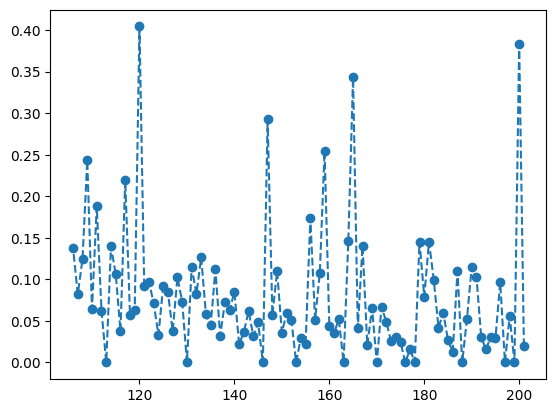

In [24]:
plt.plot(steps, train_loss, marker='o', linestyle='--')
plt.show() # shows effective learning with hyperparameters = 'auto'

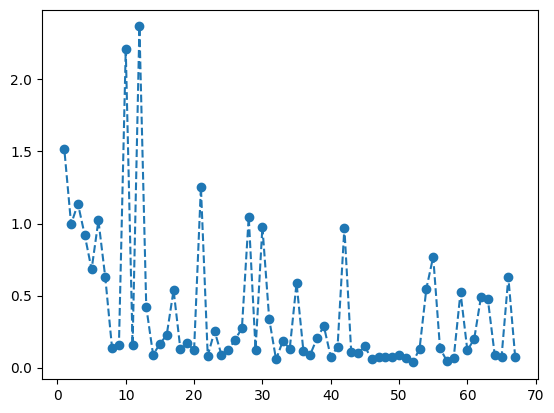

In [19]:
plt.plot(steps, train_loss, marker='o', linestyle='--')
plt.show() # shows ineffective learning with hyperparameters = 1

#Task 5 - Deploy our model

In [26]:
myLLM = retrieved_job.fine_tuned_model

In [30]:
def extract_details(user_complaint, model_name):
    """
    This function extracts information from a given user complaint using a specific LLM (Large Language Model).

    Parameters:
    user_complaint (str): The text of the user's complaint.
    model_name (str): The name of the specific LLM model to use for extraction.
    """

    system_content = """
        Given a customer complaint text, extract and return the following information in JSON (dict) format:
        - Topic
        - Problem
        - Customer_Dissatisfaction_Index
    """

    # Generate a response using the specified model and the user's complaint
    response = client.chat.completions.create(
        model = model_name,
        messages=[
            {"role": "system", "content": system_content},  # System content explaining the expected output
            {"role": "user", "content": user_complaint}  # User's complaint passed as content
        ]
    )

    # Return the content of the generated response
    return response.choices[0].message.content


In [31]:
complaint = "TV channels keep disappearing from my subscription! What's going on? Extremely annoyed with this service!"
extract_details(complaint, myLLM)

'{"Topic": "TV", "Problem": "Channels missing", "Customer_Dissatisfaction_Index": "High"}'

In [32]:
extract_details(complaint, 'gpt-4')

'{\n  "Topic": "TV Subscription Service",\n  "Problem": "TV channels disappearing from subscription",\n  "Customer_Dissatisfaction_Index": "High"\n}'

In [33]:
complaint = 'Line is down! It is really annoying!!'
extract_details(complaint, myLLM)

'{"Topic": "Internet", "Problem": "Line down", "Customer_Dissatisfaction_Index": 5}'

In [34]:
extract_details(complaint, 'gpt-4')

'{\n  "Topic": "Service Disruption",\n  "Problem" : "Line is down",\n  "Customer_Dissatisfaction_Index" : "High"\n}'

In [37]:
customer_complaint = "I am very Angry! I want my money back!"
extract_details(customer_complaint, myLLM)

'{"Topic": "Billing", "Problem": "Refund", "Customer_Dissatisfaction_Index": 5}'

In [38]:
extract_details(customer_complaint, 'gpt-4')

'{\n"Topic": "Refund",\n"Problem": "Customer demands a refund",\n"Customer_Dissatisfaction_Index": "High"\n}'

In [39]:
customer_complaint = "the internet was very slow today, it is normally fine"
extract_details(customer_complaint, myLLM)

'{"Topic": "Internet", "Problem": "Slow speed", "Customer_Dissatisfaction_Index": 3}'

In [40]:
extract_details(customer_complaint, 'gpt-4')

'{\n"Topic": "Internet",\n"Problem": "Internet was very slow today",\n"Customer_Dissatisfaction_Index": "Moderate"\n}'

## my fine-tuned LLM is generally better than the out of the box gpt-4 model
## it better captures the customer dissatisfaction index as a score
## it also better summarises the customer complaint succinctly and can pick out context like Internet was down vs. service disruption which is vague